In [223]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings

In [219]:
data = pd.read_csv('prices_ma_and_volforecast.csv')

# Correlation Analysis

In [231]:
warnings.filterwarnings("ignore")
returns_df = data.pivot_table(index='date', columns='symbol', values='returns')
closings_df = data.pivot_table(index='date', columns='symbol', values='close')

**Returns Pairplot**

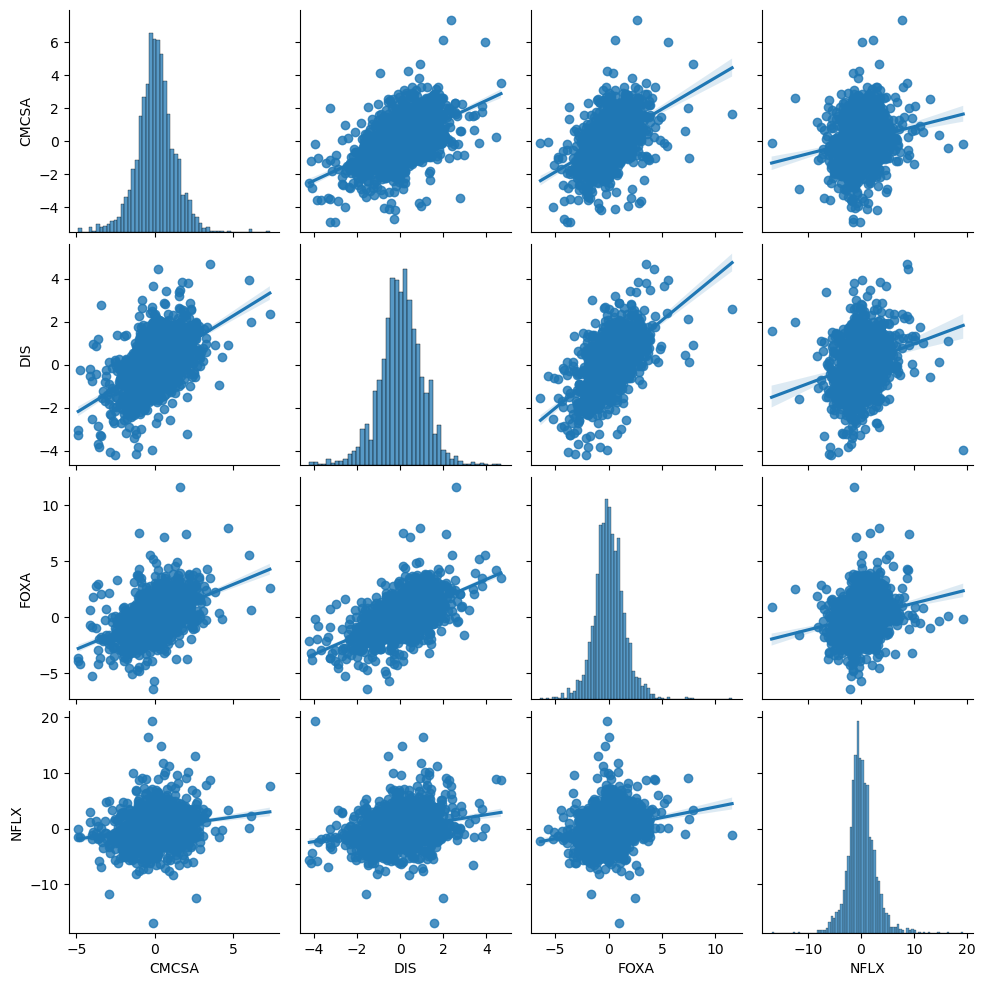

In [232]:
sns.pairplot(returns_df, kind='reg')

**Closing Price Pairplot**

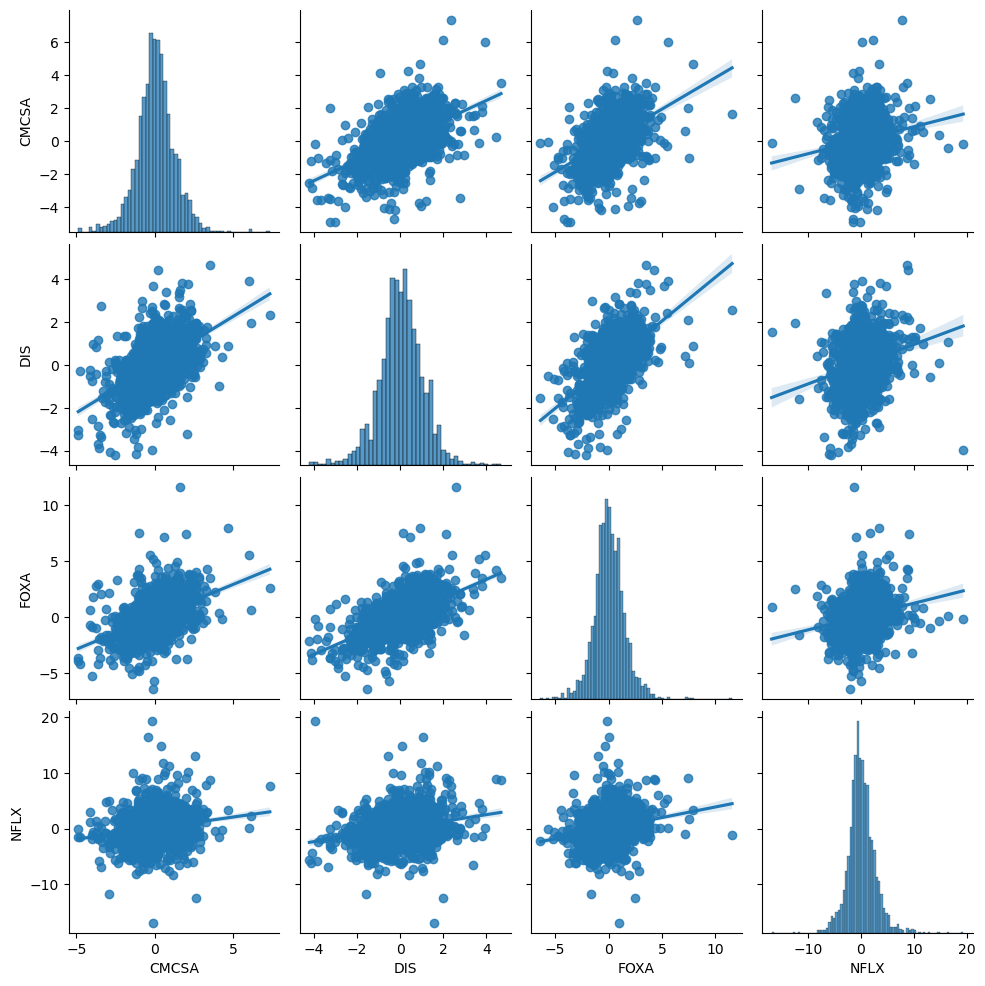

In [228]:
sns.pairplot(returns_df, kind='reg')

In [229]:
print('Returns Correlation:\n', returns_df.corr(), '\n\nClosings Correlation:\n', closings_df.corr())

Returns Correlation:
 symbol     CMCSA       DIS      FOXA      NFLX
symbol                                        
CMCSA   1.000000  0.522484  0.468784  0.180577
DIS     0.522484  1.000000  0.583251  0.236153
FOXA    0.468784  0.583251  1.000000  0.212034
NFLX    0.180577  0.236153  0.212034  1.000000 

Closings Correlation:
 symbol     CMCSA       DIS      FOXA      NFLX
symbol                                        
CMCSA   1.000000  0.963303  0.835125  0.347607
DIS     0.963303  1.000000  0.796824  0.396838
FOXA    0.835125  0.796824  1.000000  0.602318
NFLX    0.347607  0.396838  0.602318  1.000000


Something to consider: High correlation between DIS and CMSCA closing prices

In [280]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math

In [312]:
def train_LSTM(data , symbols):
    tf.random.set_seed(7)
    
    # Normalize features
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
    data = data.bfill()#(method='ffill')
    
    fig, axes = plt.subplots(math.ceil(len(symbols)/2), 2, figsize=(12, 8))

    for i, sym in enumerate(symbols):
        symData = data[data['symbol'] == sym]
        # Split Data
        features = symData.drop(columns=['close', 'date', 'symbol', '20-Day MA', '30-Day MA']).values  # Extract features excluding 'close' and 'date' columns
        target = symData['close'].values.reshape(-1, 1)  # Extract the 'close' column
        
        # Split data into training and testing sets
        split = int(0.8 * len(features))
        X_train, X_test = features[:split], features[split:]
        y_train, y_test = target[:split], target[split:]
        
        # Scaling the data
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        y_scaler = MinMaxScaler()
        y_train_scaled = y_scaler.fit_transform(y_train)
        y_test_scaled = y_scaler.transform(y_test)
    
        # Model Creation
        model = Sequential([
            LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], 1)),
            LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
            LSTM(units=64, return_sequences=True),
            LSTM(units=32),
            Flatten(),
            Dropout(0.2),
            Dense(units=16),
            Dense(units=1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        # Train the model
        print(f"Training {sym} Model...")
        model.fit(X_train_scaled, y_train_scaled, epochs=10, verbose=0) # epochs may need to be be adjusted
        
        train_loss = model.evaluate(X_train_scaled, y_train_scaled, verbose=0)
        test_loss = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
        print(f'Train Loss: {train_loss}')
        print(f'Test Loss: {test_loss}')
        
        # Make predictions
        y_pred = model.predict(X_test_scaled, verbose=0)
        y_pred_inv = y_scaler.inverse_transform(y_pred)
        y_test_inv = y_scaler.inverse_transform(y_test)
        
        # Plotting
        ax = axes[i//2][i%2]
        ax.set_title(f'{sym} Model')
        ax.set_xlabel('Date')
        ax.set_ylabel('Close Price USD ($)')
        
        # Plot training data
        ax.plot(symData['date'][:split], symData['close'][:split], label='Train')
        
        # Plot validation data
        ax.plot(symData['date'][split:], symData['close'][split:], label='Val')
        
        # Plot predictions
        lab = "Predictions"
        ax.plot(symData['date'][split:], y_pred_inv, label=lab)
        
        ax.legend(loc='lower right')
        
        # Calculate useful Error Metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_inv))
        ax.annotate(f'RMSE:{rmse}', xy=(.05, .85), xycoords='axes fraction', fontsize = 8)
        ax.annotate(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred_inv) * 100}%', xy = (.05, .75), xycoords='axes fraction', fontsize=8)
        
    plt.tight_layout()
    plt.show()

Training CMCSA Model...
Train Loss: 0.0004115927149541676
Test Loss: 0.0031190854497253895
Training DIS Model...
Train Loss: 0.0001987478754017502
Test Loss: 0.00021756163914687932
Training FOXA Model...
Train Loss: 0.0009644213714636862
Test Loss: 0.0008443107944913208
Training NFLX Model...
Train Loss: 0.0001814115821616724
Test Loss: 0.0003226518747396767


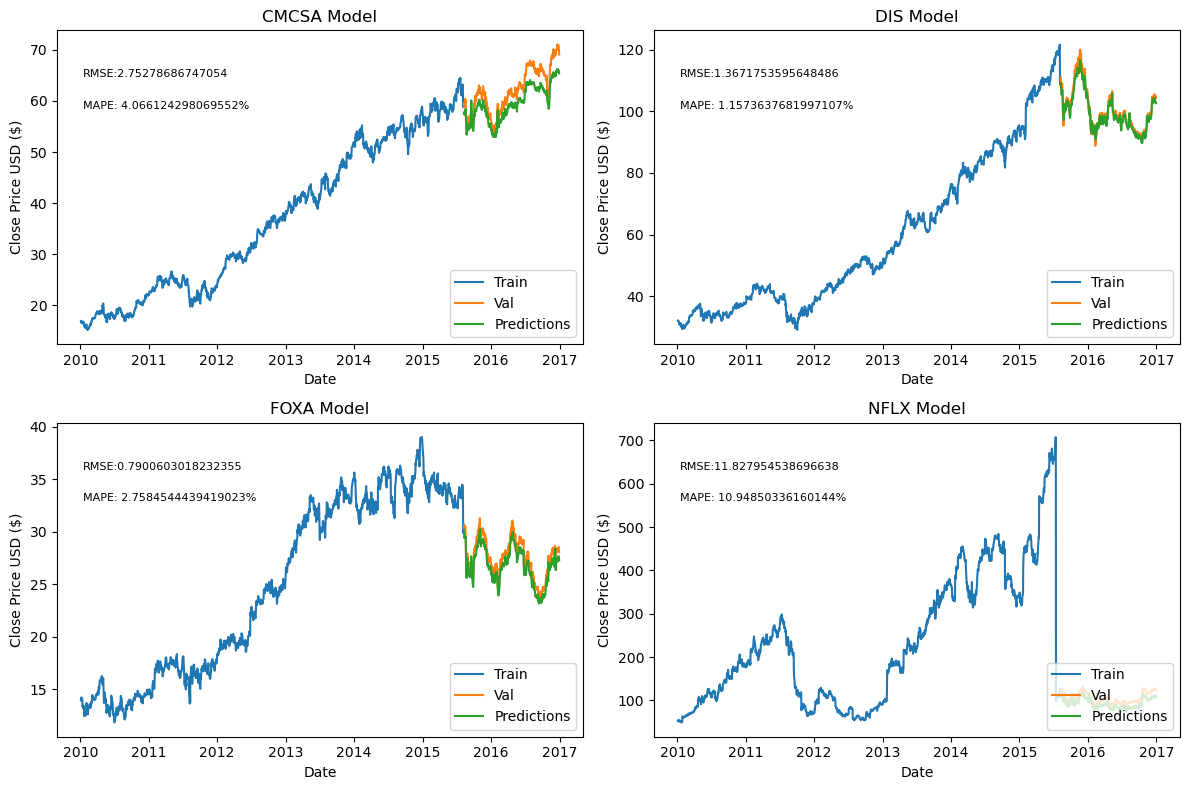

In [313]:
symbols = data['symbol'].unique()

train_LSTM(data, symbols)

In [314]:
def predict_ahead(data, symbol, days_list):

    
    data = data[data['symbol'] == symbol]
    tf.random.set_seed(7)
    
    # Normalize features
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
    data = data.bfill()  # (method='ffill')

    fig, axes = plt.subplots(math.ceil(len(days_list)/2), 2, figsize=(12, 8))
    for i, days in enumerate(days_list):
        non_ma_predictor = ['10-Day MA', '20-Day MA']
        if(days <= 10): non_ma_predictor = ['20-Day MA', '30-Day MA']
        elif(days <= 20): ma_predictor = ['10-Day MA', '30-Day MA'] 
        # Scale Data# Shift the target variable by 30 days to create the new target variable for training
        data['target'] = data['close'].shift(-days)
        
        # Remove rows with NaN values in the target column
        data.dropna(subset=['target'], inplace=True)
        
        features = data.drop(columns=['close', 'date', 'symbol'] + non_ma_predictor + ['target']).values  # Extract features excluding 'close', 'date', 'symbol', '10-Day MA', '20-Day MA', and 'target' columns
        target = data['target'].values.reshape(-1, 1)  # Use the shifted 'target' column as the new target
        
        # Split data into training and testing sets
        split = int(0.8 * len(features))
        X_train, X_test = features[:split], features[split:]
        y_train, y_test = target[:split], target[split:]
        
        # Scaling the data
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        y_scaler = MinMaxScaler()
        y_train_scaled = y_scaler.fit_transform(y_train)
        y_test_scaled = y_scaler.transform(y_test)
        
        # Model Creation
        model = Sequential([
            LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], 1)),
            LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
            LSTM(units=64, return_sequences=True),
            LSTM(units=32),
            Flatten(),
            Dropout(0.2),
            Dense(units=16),
            Dense(units=1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error', metrics='accuracy')
        
        # Train the model
        print(f"Training {symbol} Model - {days} Days Prediction") 
        history = model.fit(X_train_scaled, y_train_scaled, epochs=10, verbose = 0)  # epochs may need to be adjusted
        
        # Make predictions
        y_pred = model.predict(X_test_scaled, verbose=0)
        y_pred_inv = y_scaler.inverse_transform(y_pred)
        
        # Plotting
        ax = axes[i//2][i%2]
        ax.set_title(f'{symbol} Model - Predictions ({days} days ahead)')
        ax.set_xlabel('Date')
        ax.set_ylabel('Close Price USD ($)')
        
        # Plot training data
        ax.plot(data['date'][:split], data['close'][:split], label='Train')
        
        # Plot validation data
        ax.plot(data['date'][split:], data['close'][split:], label='Val')
        
        # Plot predictions
        lab = f"Predictions ({days} days ahead)"
        ax.plot(data['date'][split:], y_pred_inv, label=lab)
        
        ax.legend(loc='lower right')
        
        # Calculate useful Error Metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_inv))
        ax.annotate(f'RMSE:{rmse}', xy=(.05, .85), xycoords='axes fraction', fontsize = 8)
        ax.annotate(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred_inv) * 100}%', xy = (.05, .75), xycoords='axes fraction', fontsize=8)
        
    plt.tight_layout()
    # Hide unused plot
    axes[2,1].set_visible(False)
    plt.show()
        
        

Training CMCSA Model - 10 Days Prediction
Training CMCSA Model - 20 Days Prediction
Training CMCSA Model - 30 Days Prediction
Training CMCSA Model - 60 Days Prediction
Training CMCSA Model - 120 Days Prediction


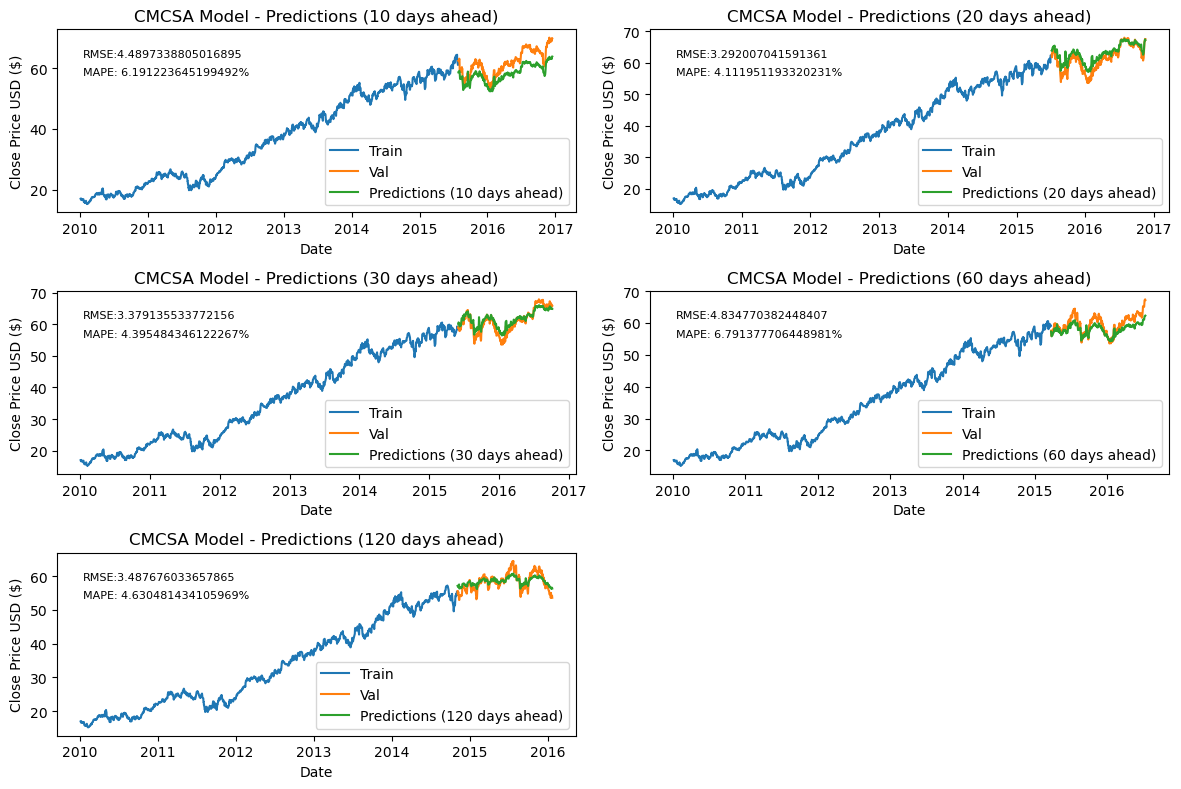

Training DIS Model - 10 Days Prediction
Training DIS Model - 20 Days Prediction
Training DIS Model - 30 Days Prediction
Training DIS Model - 60 Days Prediction
Training DIS Model - 120 Days Prediction


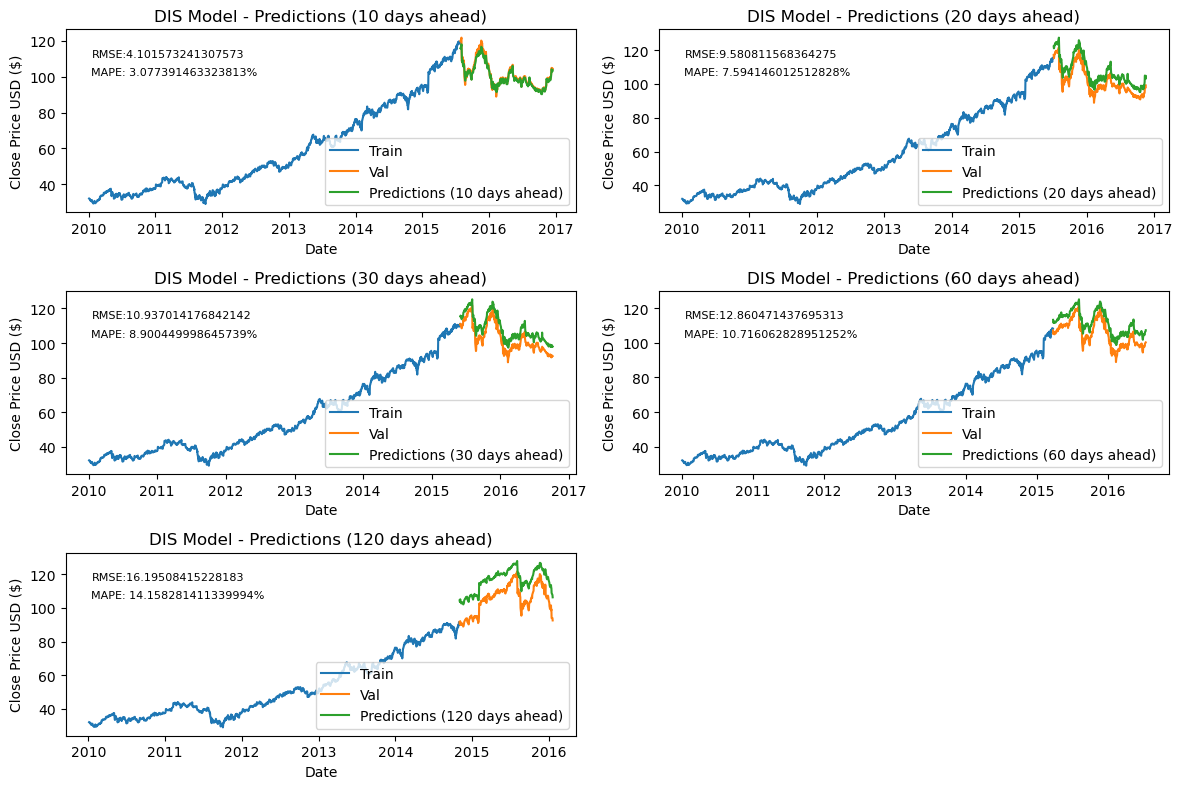

Training FOXA Model - 10 Days Prediction
Training FOXA Model - 20 Days Prediction
Training FOXA Model - 30 Days Prediction
Training FOXA Model - 60 Days Prediction
Training FOXA Model - 120 Days Prediction


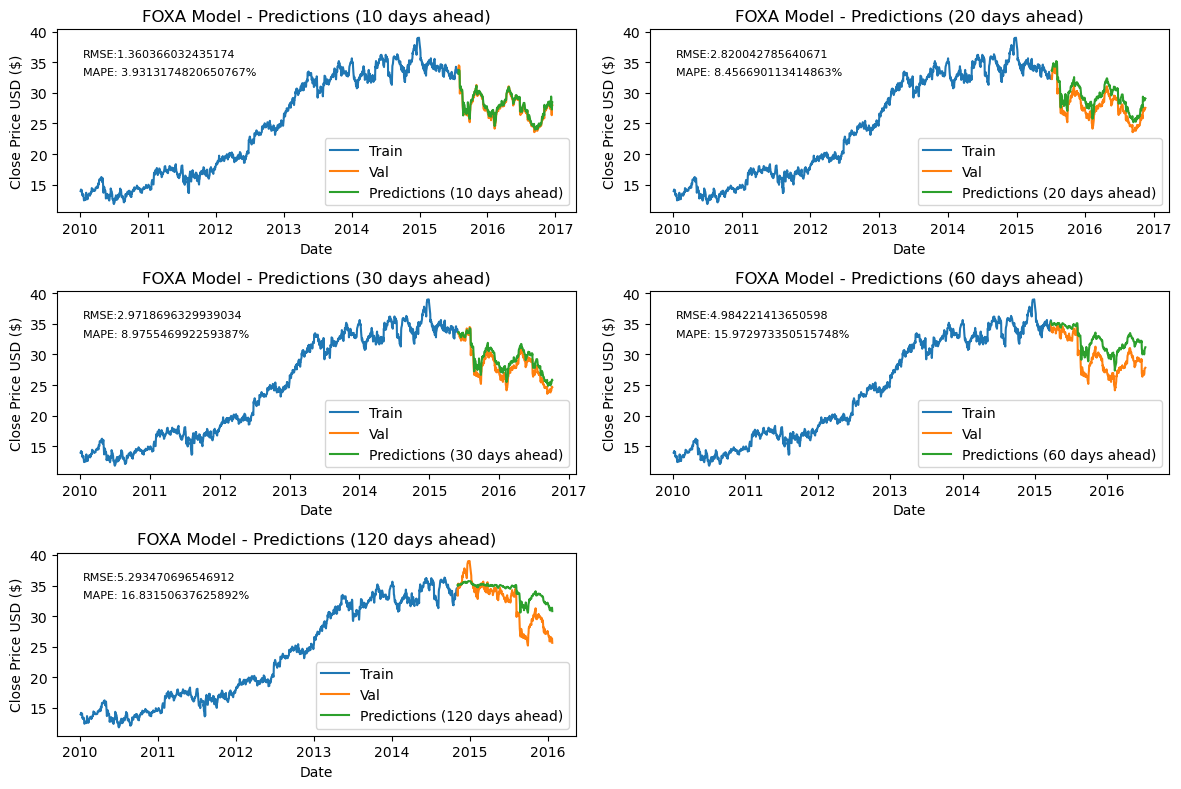

Training NFLX Model - 10 Days Prediction
Training NFLX Model - 20 Days Prediction
Training NFLX Model - 30 Days Prediction
Training NFLX Model - 60 Days Prediction
Training NFLX Model - 120 Days Prediction


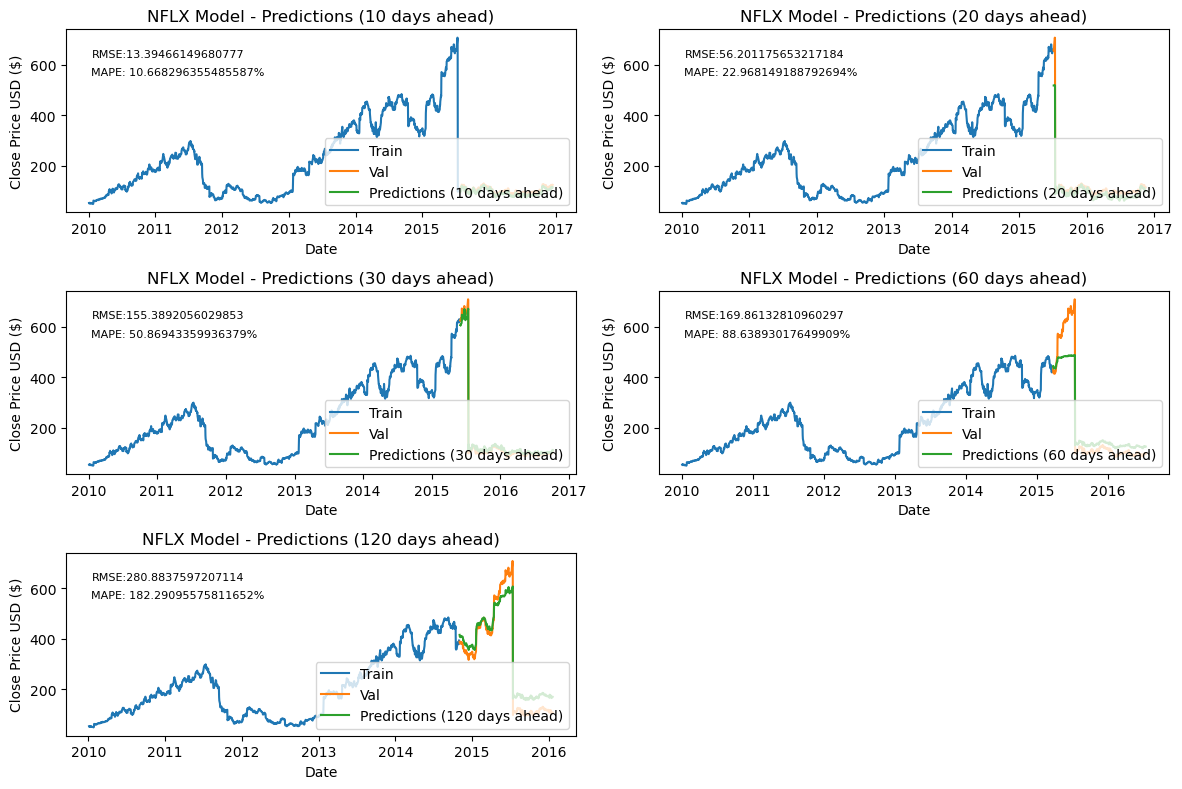

In [315]:
symbols = data['symbol'].unique()

for sym in symbols:
    predict_ahead(data,sym, [10, 20, 30, 60, 120])